In [1]:
from helpers import load_fashion_dataset, binarize_image
X_train, X_test = load_fashion_dataset()

N_STORED_PATTERNS = 5

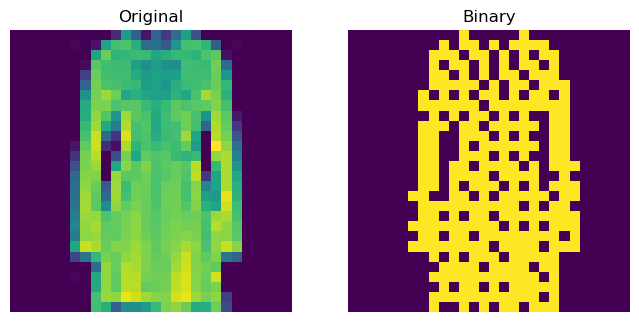

In [2]:
import matplotlib.pyplot as plt
import numpy as np
stored_patterns_indices = np.random.choice(len(X_train), N_STORED_PATTERNS, replace=False)
stored_patterns = X_train[stored_patterns_indices]["image"]
stored_patterns_binary = np.array([x.flatten() for x in binarize_image(stored_patterns)])

sample_pattern = stored_patterns[1]
sample_pattern_binary = stored_patterns_binary[1].reshape(28,28)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# left: Original image
axes[0].imshow(sample_pattern)
axes[0].set_title("Original")
axes[0].axis('off')

# right: Binarized Image
axes[1].imshow(sample_pattern_binary)
axes[1].set_title("Binary")
axes[1].axis('off')

plt.show()

In [7]:
print(sample_pattern)

<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x177C78AA0>


In [150]:
from Hopfield import Hopfield
from utils.activation_functions import sgn
n_neurons = len(stored_patterns_binary[0])
hopfield_network = Hopfield(activation_function=sgn, n_neurons=n_neurons)

hopfield_network.bind(stored_patterns_binary)
print(hopfield_network.W)


[[0.         0.00510204 0.00510204 ... 0.00510204 0.00510204 0.00510204]
 [0.00510204 0.         0.00510204 ... 0.00510204 0.00510204 0.00510204]
 [0.00510204 0.00510204 0.         ... 0.00510204 0.00510204 0.00510204]
 ...
 [0.00510204 0.00510204 0.00510204 ... 0.         0.00510204 0.00510204]
 [0.00510204 0.00510204 0.00510204 ... 0.00510204 0.         0.00510204]
 [0.00510204 0.00510204 0.00510204 ... 0.00510204 0.00510204 0.        ]]


In [151]:
from helpers import add_noise_classical
from utils.metrics import similarity
test_state = stored_patterns_binary[np.random.randint(0, N_STORED_PATTERNS)]
# Something weird. even if noise_level is set to 0, the network still can't retrieve some patterns
# Maybe correlations between saved patterns? To do: build correlation map between stored patterns
# Retrieval accuracy remains constant as you reach a certain noise_level. Decreasing the noise_level anywhere below of that value
# will not yield any better retrieval accuracy. It reflects cross-talk interferencen between stored patterns. To do: retrieval accuracy vs noise_level
# To do: number of correct recalls vs number stored patterns
noisy_test_state = add_noise_classical(test_state, noise_level=0.25) 


retrieved_image, closest_stored_pattern = hopfield_network.retrieve(noisy_test_state, synchrous=True, n_iterations=1000) # Synchrous iterations converge faster than asynchrous

is_correct = (similarity(closest_stored_pattern, test_state) == 1)
if is_correct:
    similar = similarity(retrieved_image, test_state)
    print(f"The network successfully retrieved the correct pattern. Equilibrium state is {similar * 100:.2f}% similar to the stored pattern ")
else:
    print('The network retrieved the wrong pattern!')


The network successfully retrieved the correct pattern. Equilibrium state is 92.86% similar to the stored pattern 


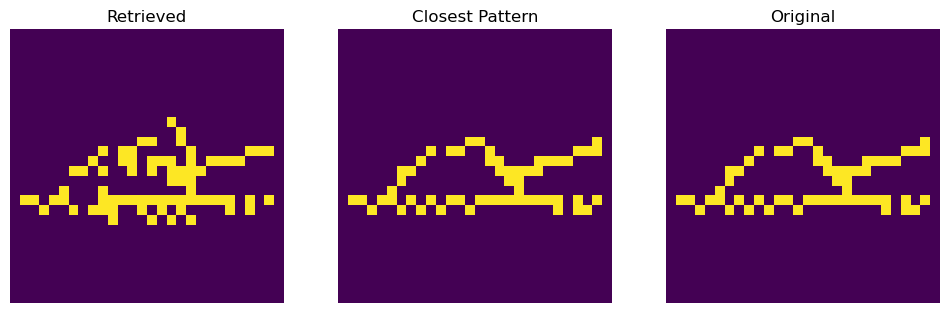

In [152]:
import matplotlib.pyplot as plt
retrieved_image = retrieved_image.reshape(28, 28)
closest_stored_pattern = closest_stored_pattern.reshape(28, 28)
# create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 8))

# left: retrieved pattern
axes[0].imshow(retrieved_image)
axes[0].set_title("Retrieved")
axes[0].axis('off')

# middle: predicted closest stored pattern
axes[1].imshow(closest_stored_pattern)
axes[1].set_title("Closest Pattern")
axes[1].axis('off')

# right: original sample
axes[2].imshow(test_state.reshape(28, 28))
axes[2].set_title("Original")
axes[2].axis('off')


plt.show()

# Continous Hopfield Network

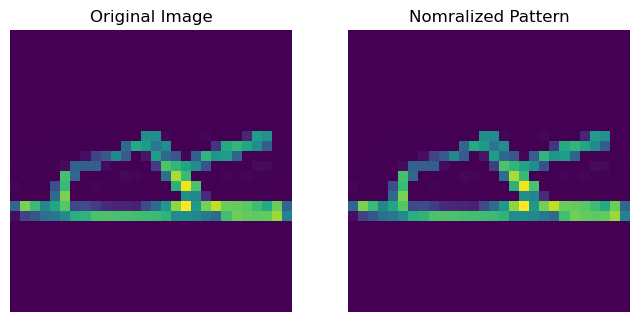

In [3]:
from helpers import normalize_image
stored_patterns_indices = np.random.choice(len(X_train), N_STORED_PATTERNS, replace=False)
stored_patterns = X_train[stored_patterns_indices]["image"]
stored_patterns_binary = np.array([x.flatten() for x in binarize_image(stored_patterns)])

sample_pattern = stored_patterns[1]
sample_pattern_normalized = normalize_image(sample_pattern)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(sample_pattern)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(sample_pattern_normalized)
axes[1].set_title("Nomralized Pattern")
axes[1].axis('off')

plt.show()


In [4]:
from utils.activation_functions import tanh
from Hopfield import Hopfield

stored_patterns_normalized = np.array([normalize_image(pattern).flatten() for pattern in stored_patterns])
n_neurons = len(stored_patterns_normalized[0])
hopfield_network_continous = Hopfield(activation_function=tanh, n_neurons=n_neurons)

hopfield_network_continous.bind(stored_patterns_normalized)

In [23]:
def add_noise_normal(state, noise_level=0.25):
    """
    Adds zero-mean Gaussian noise to a continuous state vector.

    Parameters
    ----------
    state : np.ndarray
        Continuous state vector (e.g., neuron activations).
    noise_level : float
        Standard deviation of the Gaussian noise.

    Returns
    -------
    noisy_state : np.ndarray
        State with added Gaussian noise.
    """
    noisy_state = state.copy()
    noise = np.random.normal(0, noise_level, size=len(state))
    return noisy_state + noise

test_stored_pattern = stored_patterns_normalized[np.random.randint(0, N_STORED_PATTERNS)]
test_noisy = add_noise_normal(test_stored_pattern, noise_level=0.1)

retrieved_image, closest_stored_pattern = hopfield_network_continous.retrieve(test_noisy, synchrous=True, n_iterations=20, beta = 5) # Synchrous iterations converge faster than asynchrous


In [27]:
print(N_STORED_PATTERNS)

4


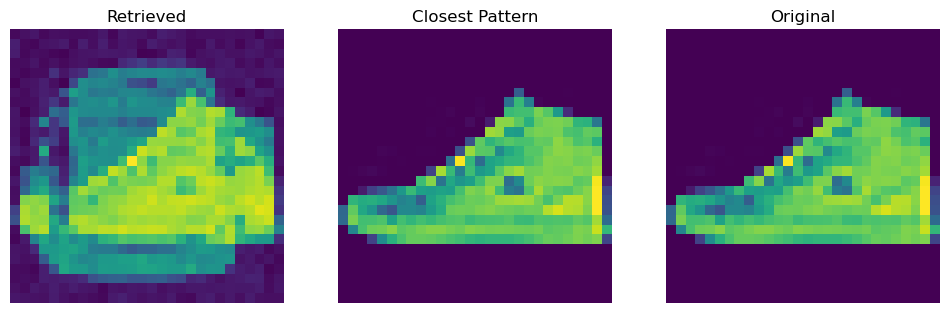

In [24]:
retrieved_image = retrieved_image.reshape(28, 28)
closest_stored_pattern = closest_stored_pattern.reshape(28, 28)

fig, axes = plt.subplots(1, 3, figsize=(12, 8))

# left: retrieved pattern
axes[0].imshow(retrieved_image)
axes[0].set_title("Retrieved")
axes[0].axis('off')

# middle: predicted closest stored pattern
axes[1].imshow(closest_stored_pattern)
axes[1].set_title("Closest Pattern")
axes[1].axis('off')

# right: original sample
axes[2].imshow(test_stored_pattern.reshape(28, 28))
axes[2].set_title("Original")
axes[2].axis('off')


plt.show()